In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTModel

In [ ]:
# Mount Google Drive (only for Colab)
drive.mount('/content/drive')

# ========================================================================
# 1. Dataset Configuration
# ========================================================================
dataset_paths = {
    'Normal': '/content/drive/MyDrive/OS Dataset/Normal/',
    'Osteopenia': '/content/drive/MyDrive/OS Dataset/Osteopenia/',
    'Osteoporosis': '/content/drive/MyDrive/OS Dataset/Osteoporosis/'
}

# ========================================================================
# 2. Image Loading & Preprocessing
# ========================================================================
def load_images_and_labels(folder_path, label):
    images = []
    labels = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(folder_path, filename)
            try:
                # Load image and verify successful read
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue

                # Critical Fix 1: Resize to ViT's required 224x224
                img = cv2.resize(img, (224, 224))

                # Critical Fix 2: Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Critical Fix 3: Convert to channels-first format
                img = np.transpose(img, (2, 0, 1))  # (3, 224, 224)

                # Critical Fix 4: Normalize to [-1, 1] range
                img = (img.astype(np.float32) / 127.5) - 1.0

                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(images), np.array(labels)

# ========================================================================
# 3. Load and Prepare Data
# ========================================================================
# Load datasets
normal_images, normal_labels = load_images_and_labels(dataset_paths['Normal'], 0)
osteopenia_images, osteopenia_labels = load_images_and_labels(dataset_paths['Osteopenia'], label=1)
osteoporosis_images, osteoporosis_labels = load_images_and_labels(dataset_paths['Osteoporosis'], label=2)

# Combine and shuffle data
x_data = np.concatenate([normal_images, osteopenia_images, osteoporosis_images], axis=0)
y_data = np.concatenate([normal_labels, osteopenia_labels, osteoporosis_labels], axis=0)

# Random shuffle with fixed seed for reproducibility
np.random.seed(42)
shuffle_idx = np.random.permutation(len(x_data))
x_data = x_data[shuffle_idx]
y_data = y_data[shuffle_idx]

# ========================================================================
# 4. Train/Validation/Test Split
# ========================================================================
# Stratified split to maintain class balance
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x_data, y_data,
    test_size=0.2,
    stratify=y_data,
    random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val,
    test_size=0.1,  # 10% of training for validation
    stratify=y_train_val,
    random_state=42
)

Mounted at /content/drive


In [ ]:
print(f'Number of Normal Images: {len(normal_images)}')
print(f'Number of Oesteopenia Images: {len(osteopenia_images)}')
print(f'Number of Oestroporosis Images: {len(osteoporosis_images)}')

Number of Normal Images: 780
Number of Oesteopenia Images: 374
Number of Oestroporosis Images: 793


In [ ]:
# Step 2: Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 3: DWT Implementation
def dwt_haar(img):
    """Performs Haar wavelet transform on a batch of images."""
    # img shape: (batch, channels, height, width)
    batch, channels, h, w = img.shape

    # Split rows into even and odd indices
    even_rows = img[:, :, 0::2, :]
    odd_rows = img[:, :, 1::2, :]

    # Compute row-wise averages and differences
    avg_rows = (even_rows + odd_rows) / 2
    diff_rows = (even_rows - odd_rows) / 2

    # Split columns for avg_rows (LL and HL)
    even_cols_avg = avg_rows[:, :, :, 0::2]
    odd_cols_avg = avg_rows[:, :, :, 1::2]
    LL = (even_cols_avg + odd_cols_avg) / 2
    HL = (even_cols_avg - odd_cols_avg) / 2

    # Split columns for diff_rows (LH and HH)
    even_cols_diff = diff_rows[:, :, :, 0::2]
    odd_cols_diff = diff_rows[:, :, :, 1::2]
    LH = (even_cols_diff + odd_cols_diff) / 2
    HH = (even_cols_diff - odd_cols_diff) / 2

    return torch.cat([LL, HL, LH, HH], dim=1)

# Step 4: Dataset Class (unchanged)
class NumpyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.x_data[idx]).float()
        label = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return image, label

Using device: cuda


In [ ]:
# Step 5: Modified ViT Model with DWT Processing (3-class version)
class ViTMultiClassClassifier(nn.Module):
    def __init__(self, pretrained_model='google/vit-large-patch16-224-in21k'):
        super().__init__()
        self.vit = ViTModel.from_pretrained(pretrained_model)
        self.classifier = nn.Linear(self.vit.config.hidden_size * 4, 3)  # 3 output classes
        # Removed sigmoid - CrossEntropyLoss includes softmax

        # Freeze ViT parameters
        for param in self.vit.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Apply Haar DWT
        x_dwt = dwt_haar(x)
        batch_size = x_dwt.size(0)

        # Reshape and process each subband
        x_dwt = x_dwt.view(batch_size, 4, 3, 112, 112)
        vit_outputs = []

        for i in range(4):
            subband = x_dwt[:, i, :, :, :]
            subband_up = F.interpolate(subband, size=(224, 224),
                                     mode='bilinear', align_corners=False)
            outputs = self.vit(subband_up)
            vit_outputs.append(outputs.last_hidden_state[:, 0, :])

        # Concatenate and classify
        combined = torch.cat(vit_outputs, dim=1)
        return self.classifier(combined)  # Return raw logits

# Step 6: Create Verified Datasets and DataLoaders
class NumpyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return (
            torch.tensor(self.x[index], dtype=torch.float32),
            torch.tensor(self.y[index], dtype=torch.long)  # Crucial for CrossEntropyLoss
        )

# Verify data shapes and labels first!
print("Data verification:")
print(f"Train labels: {np.unique(y_train)}")
print(f"Val labels: {np.unique(y_val)}")
print(f"Test labels: {np.unique(y_test)}")

batch_size = 32
train_dataset = NumpyDataset(x_train, y_train)
val_dataset = NumpyDataset(x_val, y_val)
test_dataset = NumpyDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Step 7: Initialize Model
model = ViTMultiClassClassifier().to(device)

# Step 8: Loss and Optimizer (3-class compatible)
criterion = nn.CrossEntropyLoss()  # Changed from BCELoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Data verification:
Train labels: [0 1 2]
Val labels: [0 1 2]
Test labels: [0 1 2]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [ ]:
import time
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# Modified training loop for 3-class classification
num_epochs = 500
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
early_stop = False
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    verbose=True
)

print(f"\n{'='*50}")
print(f"Starting training with early stopping (patience={patience})")
print(f"and learning rate scheduling (ReduceLROnPlateau)")
print(f"{'='*50}\n")

for epoch in range(num_epochs):
    if early_stop:
        print(f"[!] Early stopping triggered at epoch {epoch+1}")
        break

    epoch_start = time.time()

    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0

    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1:3d}/{num_epochs} [Train]") as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # Shape: [batch_size, 3]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_batches += 1

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'AvgLoss': f"{(train_loss/(train_batches*images.size(0))):.4f}"
            })

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with tqdm(val_loader, unit="batch", desc=f"Epoch {epoch+1:3d}/{num_epochs} [Val]  ") as pbar:
        with torch.no_grad():
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)  # Get class indices
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                pbar.set_postfix({
                    'Loss': f"{loss.item():.4f}",
                    'Acc': f"{(correct/total):.4f}"
                })

    # Calculate metrics
    epoch_train_loss = train_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    val_acc = correct / total
    current_lr = optimizer.param_groups[0]['lr']

    # Update learning rate
    scheduler.step(epoch_val_loss)

    # Store history
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Early stopping logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        improvement_msg = f"(▼ {best_val_loss - epoch_val_loss:.4f})"
    else:
        epochs_no_improve += 1
        improvement_msg = f"(▲ {epoch_val_loss - best_val_loss:.4f}) [Patience left: {patience - epochs_no_improve}]"
        if epochs_no_improve >= patience:
            early_stop = True

    # Calculate epoch duration
    epoch_time = time.time() - epoch_start
    time_remaining = (epoch_time * (num_epochs - epoch - 1)) / 3600 if not early_stop else 0

    # Detailed epoch report
    print(f"\nEpoch {epoch+1:3d}/{num_epochs} | Duration: {epoch_time:.1f}s | Remaining: ~{time_remaining:.1f}h")
    print(f"Train Loss: {epoch_train_loss:.4f}")
    print(f"Val Loss:   {epoch_val_loss:.4f} {improvement_msg}")
    print(f"Val Acc:    {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")
    print(f"-"*60)

# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))
print("\nLoaded best model weights for final testing")

# Final evaluation
model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0

with tqdm(test_loader, unit="batch", desc="Final Testing") as pbar:
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'Acc': f"{(test_correct/test_total):.4f}"
            })

print(f"\n{'='*50}")
print(f"Final Test Results:")
print(f"Loss: {test_loss/len(test_dataset):.4f}")
print(f"Accuracy: {test_correct/test_total:.4f}")
print(f"{'='*50}")


Starting training with early stopping (patience=20)
and learning rate scheduling (ReduceLROnPlateau)



Epoch   1/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.45s/batch, Loss=0.6508, Acc=0.7051]



Epoch   1/500 | Duration: 221.3s | Remaining: ~30.7h
Train Loss: 0.7548
Val Loss:   0.7275 (▼ 0.0000)
Val Acc:    0.7051
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   2/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.41s/batch, Loss=0.6260, Acc=0.6923]



Epoch   2/500 | Duration: 228.9s | Remaining: ~31.7h
Train Loss: 0.5815
Val Loss:   0.6854 (▼ 0.0000)
Val Acc:    0.6923
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   3/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.46s/batch, Loss=0.6922, Acc=0.6987]



Epoch   3/500 | Duration: 229.7s | Remaining: ~31.7h
Train Loss: 0.5319
Val Loss:   0.6465 (▼ 0.0000)
Val Acc:    0.6987
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   4/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.45s/batch, Loss=0.5971, Acc=0.7244]



Epoch   4/500 | Duration: 229.3s | Remaining: ~31.6h
Train Loss: 0.5014
Val Loss:   0.6334 (▼ 0.0000)
Val Acc:    0.7244
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   5/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.45s/batch, Loss=0.5651, Acc=0.7244]



Epoch   5/500 | Duration: 227.2s | Remaining: ~31.2h
Train Loss: 0.4507
Val Loss:   0.5919 (▼ 0.0000)
Val Acc:    0.7244
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   6/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.44s/batch, Loss=0.6176, Acc=0.7244]



Epoch   6/500 | Duration: 218.8s | Remaining: ~30.0h
Train Loss: 0.4333
Val Loss:   0.6578 (▲ 0.0660) [Patience left: 19]
Val Acc:    0.7244
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   7/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.46s/batch, Loss=0.5425, Acc=0.7372]



Epoch   7/500 | Duration: 218.8s | Remaining: ~30.0h
Train Loss: 0.4306
Val Loss:   0.6411 (▲ 0.0493) [Patience left: 18]
Val Acc:    0.7372
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   8/500 [Val]  : 100%|██████████| 5/5 [00:21<00:00,  4.40s/batch, Loss=0.5468, Acc=0.7500]



Epoch   8/500 | Duration: 218.1s | Remaining: ~29.8h
Train Loss: 0.4123
Val Loss:   0.5975 (▲ 0.0057) [Patience left: 17]
Val Acc:    0.7500
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   9/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.40s/batch, Loss=0.5296, Acc=0.6987]



Epoch   9/500 | Duration: 236.8s | Remaining: ~32.3h
Train Loss: 0.3840
Val Loss:   0.5891 (▼ 0.0000)
Val Acc:    0.6987
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  10/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.42s/batch, Loss=0.5443, Acc=0.7179]



Epoch  10/500 | Duration: 227.0s | Remaining: ~30.9h
Train Loss: 0.3701
Val Loss:   0.5857 (▼ 0.0000)
Val Acc:    0.7179
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  11/500 [Val]  : 100%|██████████| 5/5 [00:21<00:00,  4.39s/batch, Loss=0.5271, Acc=0.7436]



Epoch  11/500 | Duration: 246.0s | Remaining: ~33.4h
Train Loss: 0.3501
Val Loss:   0.5649 (▼ 0.0000)
Val Acc:    0.7436
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  12/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.45s/batch, Loss=0.4863, Acc=0.7372]



Epoch  12/500 | Duration: 224.0s | Remaining: ~30.4h
Train Loss: 0.3421
Val Loss:   0.5550 (▼ 0.0000)
Val Acc:    0.7372
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  13/500 [Val]  : 100%|██████████| 5/5 [00:21<00:00,  4.39s/batch, Loss=0.4976, Acc=0.7564]



Epoch  13/500 | Duration: 218.5s | Remaining: ~29.6h
Train Loss: 0.3438
Val Loss:   0.5981 (▲ 0.0431) [Patience left: 19]
Val Acc:    0.7564
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  14/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.41s/batch, Loss=0.6075, Acc=0.6987]



Epoch  14/500 | Duration: 218.7s | Remaining: ~29.5h
Train Loss: 0.3672
Val Loss:   0.5807 (▲ 0.0257) [Patience left: 18]
Val Acc:    0.6987
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  15/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.44s/batch, Loss=0.4922, Acc=0.7500]



Epoch  15/500 | Duration: 218.6s | Remaining: ~29.4h
Train Loss: 0.3410
Val Loss:   0.5674 (▲ 0.0123) [Patience left: 17]
Val Acc:    0.7500
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  16/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.45s/batch, Loss=0.4847, Acc=0.7500]



Epoch  16/500 | Duration: 243.2s | Remaining: ~32.7h
Train Loss: 0.3046
Val Loss:   0.5365 (▼ 0.0000)
Val Acc:    0.7500
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  17/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.42s/batch, Loss=0.4592, Acc=0.7500]



Epoch  17/500 | Duration: 219.2s | Remaining: ~29.4h
Train Loss: 0.2917
Val Loss:   0.5652 (▲ 0.0287) [Patience left: 19]
Val Acc:    0.7500
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  18/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.44s/batch, Loss=0.4961, Acc=0.7564]



Epoch  18/500 | Duration: 218.6s | Remaining: ~29.3h
Train Loss: 0.2946
Val Loss:   0.6250 (▲ 0.0885) [Patience left: 18]
Val Acc:    0.7564
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  19/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.44s/batch, Loss=0.5431, Acc=0.7564]



Epoch  19/500 | Duration: 218.7s | Remaining: ~29.2h
Train Loss: 0.2868
Val Loss:   0.5573 (▲ 0.0208) [Patience left: 17]
Val Acc:    0.7564
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  20/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.44s/batch, Loss=0.5115, Acc=0.7436]



Epoch  20/500 | Duration: 218.8s | Remaining: ~29.2h
Train Loss: 0.2999
Val Loss:   0.5485 (▲ 0.0119) [Patience left: 16]
Val Acc:    0.7436
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  21/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.43s/batch, Loss=0.4632, Acc=0.7564]



Epoch  21/500 | Duration: 218.3s | Remaining: ~29.0h
Train Loss: 0.2749
Val Loss:   0.5623 (▲ 0.0258) [Patience left: 15]
Val Acc:    0.7564
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  22/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.46s/batch, Loss=0.4530, Acc=0.7500]



Epoch  22/500 | Duration: 218.9s | Remaining: ~29.1h
Train Loss: 0.2769
Val Loss:   0.6090 (▲ 0.0725) [Patience left: 14]
Val Acc:    0.7500
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  23/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.43s/batch, Loss=0.4556, Acc=0.7500]



Epoch  23/500 | Duration: 218.4s | Remaining: ~28.9h
Train Loss: 0.2482
Val Loss:   0.5615 (▲ 0.0250) [Patience left: 13]
Val Acc:    0.7500
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  24/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.40s/batch, Loss=0.4526, Acc=0.7692]



Epoch  24/500 | Duration: 218.9s | Remaining: ~28.9h
Train Loss: 0.2408
Val Loss:   0.5375 (▲ 0.0010) [Patience left: 12]
Val Acc:    0.7692
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  25/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.44s/batch, Loss=0.4565, Acc=0.7692]



Epoch  25/500 | Duration: 248.6s | Remaining: ~32.8h
Train Loss: 0.2405
Val Loss:   0.5362 (▼ 0.0000)
Val Acc:    0.7692
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  26/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.41s/batch, Loss=0.4525, Acc=0.7692]



Epoch  26/500 | Duration: 219.3s | Remaining: ~28.9h
Train Loss: 0.2401
Val Loss:   0.5372 (▲ 0.0009) [Patience left: 19]
Val Acc:    0.7692
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  27/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.41s/batch, Loss=0.4474, Acc=0.7692]



Epoch  27/500 | Duration: 218.5s | Remaining: ~28.7h
Train Loss: 0.2398
Val Loss:   0.5380 (▲ 0.0017) [Patience left: 18]
Val Acc:    0.7692
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  28/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.46s/batch, Loss=0.4617, Acc=0.7821]



Epoch  28/500 | Duration: 246.8s | Remaining: ~32.4h
Train Loss: 0.2382
Val Loss:   0.5319 (▼ 0.0000)
Val Acc:    0.7821
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  29/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.45s/batch, Loss=0.4483, Acc=0.7756]



Epoch  29/500 | Duration: 219.5s | Remaining: ~28.7h
Train Loss: 0.2409
Val Loss:   0.5352 (▲ 0.0032) [Patience left: 19]
Val Acc:    0.7756
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  30/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.44s/batch, Loss=0.4572, Acc=0.7436]



Epoch  30/500 | Duration: 219.3s | Remaining: ~28.6h
Train Loss: 0.2371
Val Loss:   0.5461 (▲ 0.0142) [Patience left: 18]
Val Acc:    0.7436
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  31/500 [Val]  : 100%|██████████| 5/5 [00:21<00:00,  4.40s/batch, Loss=0.4498, Acc=0.7500]



Epoch  31/500 | Duration: 218.5s | Remaining: ~28.5h
Train Loss: 0.2381
Val Loss:   0.5553 (▲ 0.0233) [Patience left: 17]
Val Acc:    0.7500
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  32/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.45s/batch, Loss=0.4410, Acc=0.7500]



Epoch  32/500 | Duration: 219.1s | Remaining: ~28.5h
Train Loss: 0.2375
Val Loss:   0.5492 (▲ 0.0173) [Patience left: 16]
Val Acc:    0.7500
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  33/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.44s/batch, Loss=0.4547, Acc=0.7885]



Epoch  33/500 | Duration: 240.9s | Remaining: ~31.2h
Train Loss: 0.2370
Val Loss:   0.5299 (▼ 0.0000)
Val Acc:    0.7885
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  34/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.40s/batch, Loss=0.4513, Acc=0.7756]



Epoch  34/500 | Duration: 219.6s | Remaining: ~28.4h
Train Loss: 0.2354
Val Loss:   0.5351 (▲ 0.0052) [Patience left: 19]
Val Acc:    0.7756
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  35/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.45s/batch, Loss=0.4487, Acc=0.7756]



Epoch  35/500 | Duration: 218.9s | Remaining: ~28.3h
Train Loss: 0.2348
Val Loss:   0.5388 (▲ 0.0089) [Patience left: 18]
Val Acc:    0.7756
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  36/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.43s/batch, Loss=0.4497, Acc=0.7500]



Epoch  36/500 | Duration: 218.5s | Remaining: ~28.2h
Train Loss: 0.2341
Val Loss:   0.5639 (▲ 0.0340) [Patience left: 17]
Val Acc:    0.7500
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  37/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.43s/batch, Loss=0.4414, Acc=0.7436]



Epoch  37/500 | Duration: 218.8s | Remaining: ~28.1h
Train Loss: 0.2354
Val Loss:   0.5401 (▲ 0.0102) [Patience left: 16]
Val Acc:    0.7436
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  38/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.44s/batch, Loss=0.4472, Acc=0.7885]



Epoch  38/500 | Duration: 240.3s | Remaining: ~30.8h
Train Loss: 0.2338
Val Loss:   0.5271 (▼ 0.0000)
Val Acc:    0.7885
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  39/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.42s/batch, Loss=0.4603, Acc=0.7756]



Epoch  39/500 | Duration: 219.3s | Remaining: ~28.1h
Train Loss: 0.2344
Val Loss:   0.5356 (▲ 0.0085) [Patience left: 19]
Val Acc:    0.7756
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  40/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.43s/batch, Loss=0.4358, Acc=0.7436]



Epoch  40/500 | Duration: 219.4s | Remaining: ~28.0h
Train Loss: 0.2314
Val Loss:   0.5414 (▲ 0.0143) [Patience left: 18]
Val Acc:    0.7436
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  41/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.41s/batch, Loss=0.4549, Acc=0.7756]



Epoch  41/500 | Duration: 218.4s | Remaining: ~27.8h
Train Loss: 0.2322
Val Loss:   0.5325 (▲ 0.0054) [Patience left: 17]
Val Acc:    0.7756
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  42/500 [Val]  : 100%|██████████| 5/5 [00:21<00:00,  4.39s/batch, Loss=0.4470, Acc=0.7692]



Epoch  42/500 | Duration: 217.5s | Remaining: ~27.7h
Train Loss: 0.2314
Val Loss:   0.5361 (▲ 0.0090) [Patience left: 16]
Val Acc:    0.7692
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  43/500 [Val]  : 100%|██████████| 5/5 [00:21<00:00,  4.38s/batch, Loss=0.4446, Acc=0.7692]



Epoch  43/500 | Duration: 217.1s | Remaining: ~27.6h
Train Loss: 0.2312
Val Loss:   0.5379 (▲ 0.0109) [Patience left: 15]
Val Acc:    0.7692
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  44/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.43s/batch, Loss=0.4431, Acc=0.7436]



Epoch  44/500 | Duration: 217.5s | Remaining: ~27.5h
Train Loss: 0.2298
Val Loss:   0.5468 (▲ 0.0197) [Patience left: 14]
Val Acc:    0.7436
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  45/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.43s/batch, Loss=0.4449, Acc=0.7436]



Epoch  45/500 | Duration: 217.4s | Remaining: ~27.5h
Train Loss: 0.2288
Val Loss:   0.5412 (▲ 0.0141) [Patience left: 13]
Val Acc:    0.7436
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  46/500 [Val]  : 100%|██████████| 5/5 [00:21<00:00,  4.40s/batch, Loss=0.4462, Acc=0.7564]



Epoch  46/500 | Duration: 217.2s | Remaining: ~27.4h
Train Loss: 0.2277
Val Loss:   0.5381 (▲ 0.0111) [Patience left: 12]
Val Acc:    0.7564
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  47/500 [Val]  : 100%|██████████| 5/5 [00:21<00:00,  4.39s/batch, Loss=0.4474, Acc=0.7692]



Epoch  47/500 | Duration: 217.5s | Remaining: ~27.4h
Train Loss: 0.2275
Val Loss:   0.5362 (▲ 0.0091) [Patience left: 11]
Val Acc:    0.7692
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  48/500 [Val]  : 100%|██████████| 5/5 [00:21<00:00,  4.39s/batch, Loss=0.4463, Acc=0.7692]



Epoch  48/500 | Duration: 217.2s | Remaining: ~27.3h
Train Loss: 0.2278
Val Loss:   0.5373 (▲ 0.0103) [Patience left: 10]
Val Acc:    0.7692
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  49/500 [Val]  : 100%|██████████| 5/5 [00:21<00:00,  4.39s/batch, Loss=0.4477, Acc=0.7692]



Epoch  49/500 | Duration: 217.3s | Remaining: ~27.2h
Train Loss: 0.2274
Val Loss:   0.5369 (▲ 0.0098) [Patience left: 9]
Val Acc:    0.7692
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  50/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.42s/batch, Loss=0.4475, Acc=0.7692]



Epoch  50/500 | Duration: 217.3s | Remaining: ~27.2h
Train Loss: 0.2275
Val Loss:   0.5370 (▲ 0.0100) [Patience left: 8]
Val Acc:    0.7692
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  51/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.44s/batch, Loss=0.4476, Acc=0.7692]



Epoch  51/500 | Duration: 217.3s | Remaining: ~27.1h
Train Loss: 0.2271
Val Loss:   0.5373 (▲ 0.0102) [Patience left: 7]
Val Acc:    0.7692
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  52/500 [Val]  : 100%|██████████| 5/5 [00:21<00:00,  4.40s/batch, Loss=0.4476, Acc=0.7692]



Epoch  52/500 | Duration: 217.2s | Remaining: ~27.0h
Train Loss: 0.2271
Val Loss:   0.5372 (▲ 0.0101) [Patience left: 6]
Val Acc:    0.7692
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  53/500 [Val]  : 100%|██████████| 5/5 [00:21<00:00,  4.39s/batch, Loss=0.4474, Acc=0.7692]



Epoch  53/500 | Duration: 217.2s | Remaining: ~27.0h
Train Loss: 0.2271
Val Loss:   0.5372 (▲ 0.0101) [Patience left: 5]
Val Acc:    0.7692
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  54/500 [Val]  : 100%|██████████| 5/5 [00:21<00:00,  4.36s/batch, Loss=0.4474, Acc=0.7692]



Epoch  54/500 | Duration: 217.2s | Remaining: ~26.9h
Train Loss: 0.2271
Val Loss:   0.5374 (▲ 0.0103) [Patience left: 4]
Val Acc:    0.7692
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  55/500 [Val]  : 100%|██████████| 5/5 [00:21<00:00,  4.38s/batch, Loss=0.4476, Acc=0.7692]



Epoch  55/500 | Duration: 217.3s | Remaining: ~26.9h
Train Loss: 0.2271
Val Loss:   0.5371 (▲ 0.0101) [Patience left: 3]
Val Acc:    0.7692
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  56/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.42s/batch, Loss=0.4476, Acc=0.7692]



Epoch  56/500 | Duration: 217.4s | Remaining: ~26.8h
Train Loss: 0.2271
Val Loss:   0.5372 (▲ 0.0101) [Patience left: 2]
Val Acc:    0.7692
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  57/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.45s/batch, Loss=0.4476, Acc=0.7692]



Epoch  57/500 | Duration: 218.2s | Remaining: ~26.9h
Train Loss: 0.2270
Val Loss:   0.5372 (▲ 0.0101) [Patience left: 1]
Val Acc:    0.7692
Learning Rate: 1.00e-07
------------------------------------------------------------


Epoch  58/500 [Val]  : 100%|██████████| 5/5 [00:22<00:00,  4.41s/batch, Loss=0.4476, Acc=0.7692]
<ipython-input-6-ea088a8e051e>:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu


Epoch  58/500 | Duration: 218.8s | Remaining: ~0.0h
Train Loss: 0.2270
Val Loss:   0.5372 (▲ 0.0101) [Patience left: 0]
Val Acc:    0.7692
Learning Rate: 1.00e-07
------------------------------------------------------------
[!] Early stopping triggered at epoch 59

Loaded best model weights for final testing


Final Testing: 100%|██████████| 13/13 [00:55<00:00,  4.24s/batch, Loss=0.6394, Acc=0.8128]


Final Test Results:
Loss: 0.4926
Accuracy: 0.8128


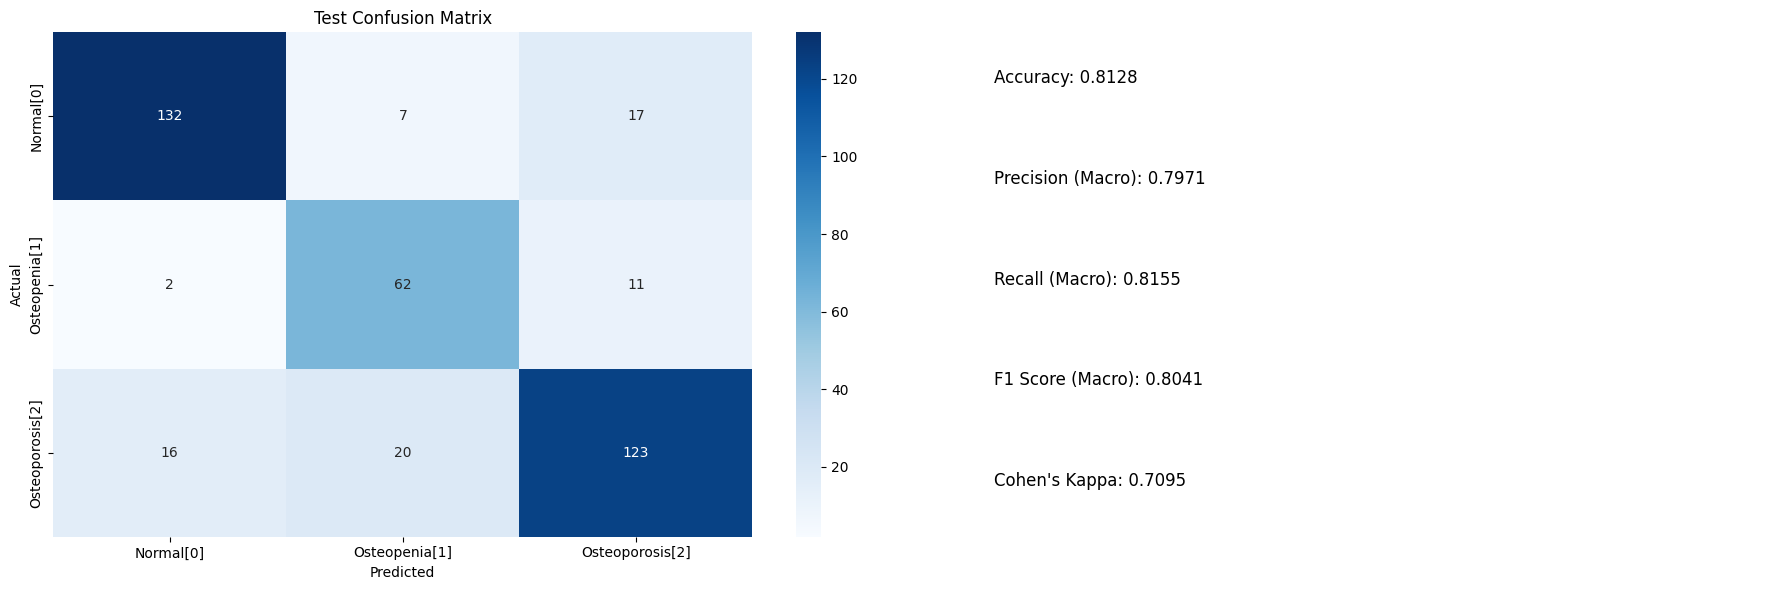

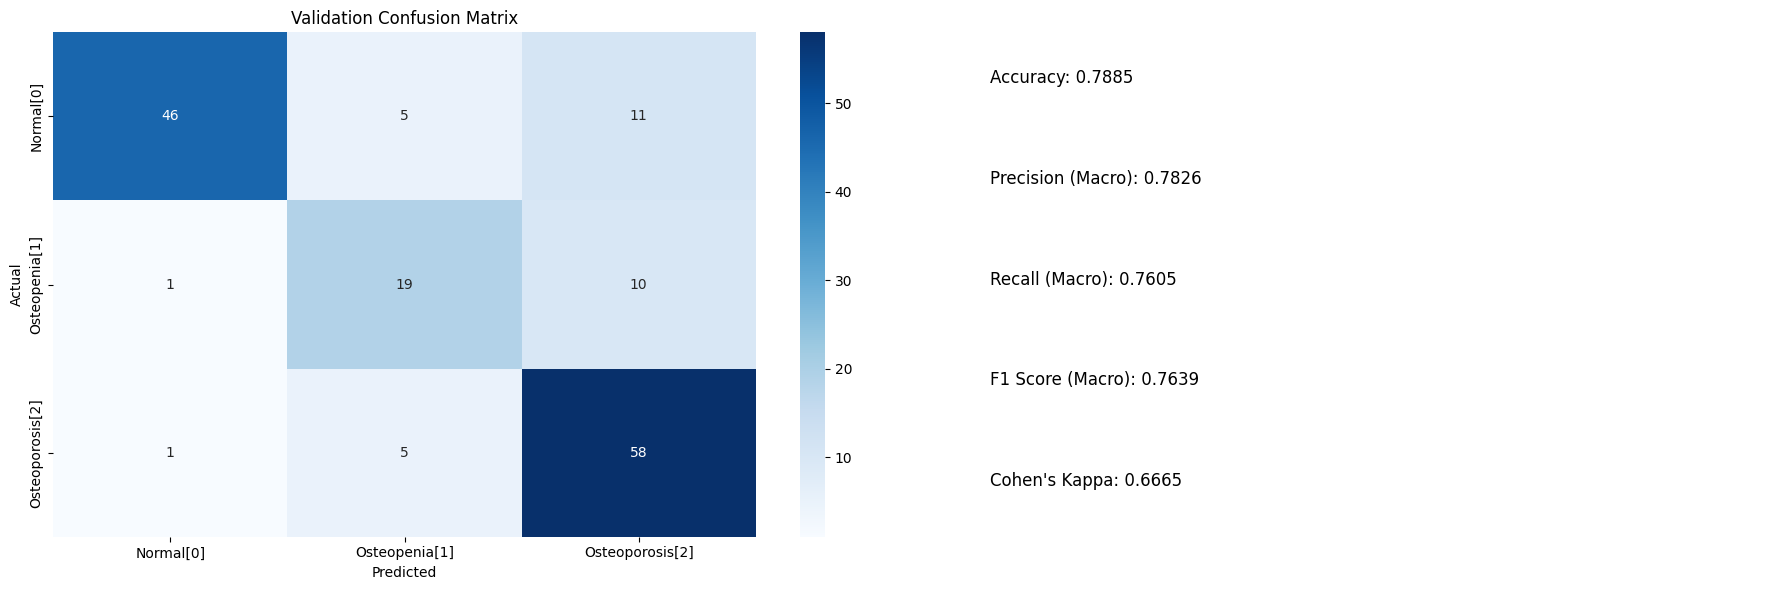

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# For accuracy graph (assuming you have training history)
train_accuracies = []  # Populate these during training
val_accuracies = []    # Populate these during validation

def plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa):
    plt.figure(figsize=(18, 6))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal[0]', 'Osteopenia[1]', 'Osteoporosis[2]'],
                yticklabels=['Normal[0]', 'Osteopenia[1]', 'Osteoporosis[2]'])
    plt.title(f'{phase_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Metrics Text
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.9, f'Accuracy: {accuracy:.4f}', fontsize=12)
    plt.text(0.1, 0.7, f'Precision (Macro): {precision:.4f}', fontsize=12)
    plt.text(0.1, 0.5, f'Recall (Macro): {recall:.4f}', fontsize=12)
    plt.text(0.1, 0.3, f'F1 Score (Macro): {f1:.4f}', fontsize=12)
    plt.text(0.1, 0.1, f"Cohen's Kappa: {kappa:.4f}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def evaluate_model(loader, phase_name):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get class predictions

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    kappa = cohen_kappa_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa)

    return accuracy

# Evaluate all sets
test_accuracy = evaluate_model(test_loader, 'Test')
val_accuracy = evaluate_model(val_loader, 'Validation')